In [25]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

Import Tabular training data

In [26]:
df = pd.read_csv(r'C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\combined_features.csv')

Prepare data for modeling

In [27]:
df_wlabs = df.drop(columns=['ID'])

In [28]:
X = df_wlabs.drop(['HWMdepth_m'], axis=1).select_dtypes(include=[np.number]).values
y = df_wlabs['HWMdepth_m'].values

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


Final feature matrix shape: (841, 27)
Target variable shape: (841,)


In [29]:
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [30]:
# First split: 70% train, 30% temp (which will be split into 15% val + 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=54)

# Second split: Split the 30% temp into 15% val and 15% test (50-50 split of the temp data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=54)

print('Number of training observations:', y_train.shape[0], f'({y_train.shape[0]/len(y)*100:.1f}%)')
print('Number of validation observations:', y_val.shape[0], f'({y_val.shape[0]/len(y)*100:.1f}%)')
print('Number of test observations:', y_test.shape[0], f'({y_test.shape[0]/len(y)*100:.1f}%)')

Number of training observations: 588 (69.9%)
Number of validation observations: 126 (15.0%)
Number of test observations: 127 (15.1%)


In [31]:
# Z-score standardization based on training set statistics (prevents data leakage)
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

# Apply z-score standardization: (X - mean) / std
X_train_norm = (X_train - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

print('Training set standardized - shape:', X_train_norm.shape)
print('Validation set standardized - shape:', X_val_norm.shape)
print('Test set standardized - shape:', X_test_norm.shape)
print('\nTraining set statistics used for standardization:')
print('Mean:', X_mean)
print('Std:', X_std)
print('\nAfter z-score standardization:')
print('Training set - Mean: {:.6f}, Std: {:.6f}'.format(X_train_norm.mean(), X_train_norm.std()))
print('Validation set - Mean: {:.6f}, Std: {:.6f}'.format(X_val_norm.mean(), X_val_norm.std()))
print('Test set - Mean: {:.6f}, Std: {:.6f}'.format(X_test_norm.mean(), X_test_norm.std()))

Training set standardized - shape: (588, 27)
Validation set standardized - shape: (126, 27)
Test set standardized - shape: (127, 27)

Training set statistics used for standardization:
Mean: [ 2.91939253e+01  4.54093860e+01  3.50358263e+01  4.89137434e+00
  9.18090000e+00  9.42401272e+00  7.43314481e+00  8.65209184e-01
  6.82429592e-01  1.14926413e+01  6.64829283e+00  1.57530469e+01
 -2.76641083e+01  6.72477345e+00 -1.04777853e+01  3.55808292e+00
  3.01744916e+00 -4.24226162e+01  7.00476966e-01 -1.81537059e+01
  6.14317992e+00  4.84417149e+00  1.72955450e+00  2.01737755e+03
 -8.62319959e-01  2.75522443e-01 -5.83149671e-01]
Std: [6.30298235e+01 7.48671789e+01 6.64507776e+01 5.43317468e+00
 1.77635684e-14 7.24200792e+00 1.02960450e+01 6.64881506e-01
 9.45269593e-01 1.25210808e+01 1.44068081e+01 2.16196508e+01
 6.14980319e+00 6.17046882e+00 1.29284498e+00 1.20189900e+00
 7.88703367e-01 7.37361606e+00 2.07773532e+00 3.77724920e+00
 4.03432270e+00 2.13718250e+00 2.65459830e-01 7.47084667e-01

Hyperparameter Tuning and Training of the RF Model

In [32]:
# Robust Hyperparameter Tuning with Cross-Validation
rf = RandomForestRegressor(random_state=54)

# Parameter grid for regression
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Cross-validation for regression
rf_cv = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=100,  # More iterations for better search
    cv=5,       # 10-fold CV for more robust evaluation
    scoring='neg_mean_squared_error',  # MSE for regression
    random_state=54,
    n_jobs=-1,   # Use all cores
    verbose=1
)

print("Starting hyperparameter optimization...")
rf_optimized = rf_cv.fit(X_train_norm, y_train)

print('Best parameters:', rf_optimized.best_params_)
print('Best cross-validation score (neg_MSE):', rf_optimized.best_score_)

Starting hyperparameter optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Best cross-validation score (neg_MSE): -2.106182283337696


In [36]:
# Model Evaluation on All Sets
best_rf = rf_optimized.best_estimator_

# Predictions on all sets
y_train_pred = best_rf.predict(X_train_norm)
y_val_pred = best_rf.predict(X_val_norm)
y_test_pred = best_rf.predict(X_test_norm)

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

def calculate_regression_metrics(y_true, y_pred, set_name):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Metrics:")
    print("-" * 30)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Calculate metrics for all sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_regression_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test")

MODEL PERFORMANCE METRICS

Training Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.2186
Root Mean Squared Error (RMSE): 0.4676
Mean Absolute Error (MAE): 0.1194
R² Score: 0.9199

Validation Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.6026
Root Mean Squared Error (RMSE): 0.7762
Mean Absolute Error (MAE): 0.5394
R² Score: 0.6247

Test Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.5233
Root Mean Squared Error (RMSE): 0.7234
Mean Absolute Error (MAE): 0.4832
R² Score: 0.6515


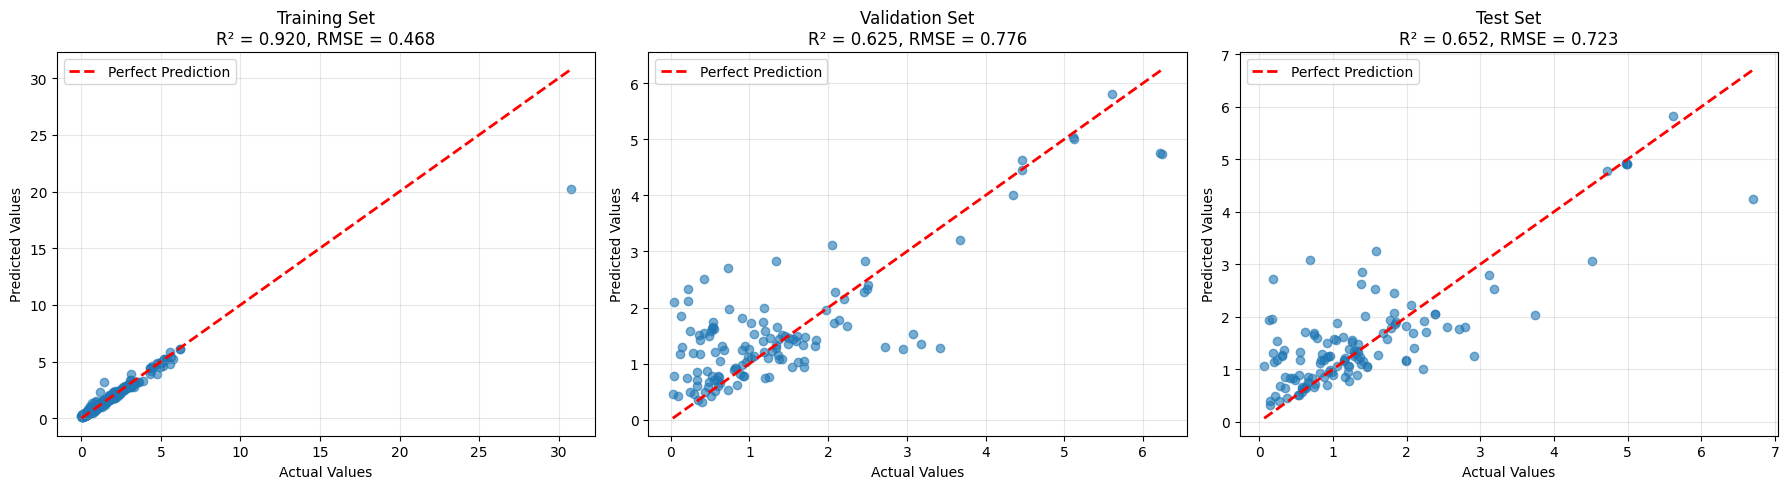

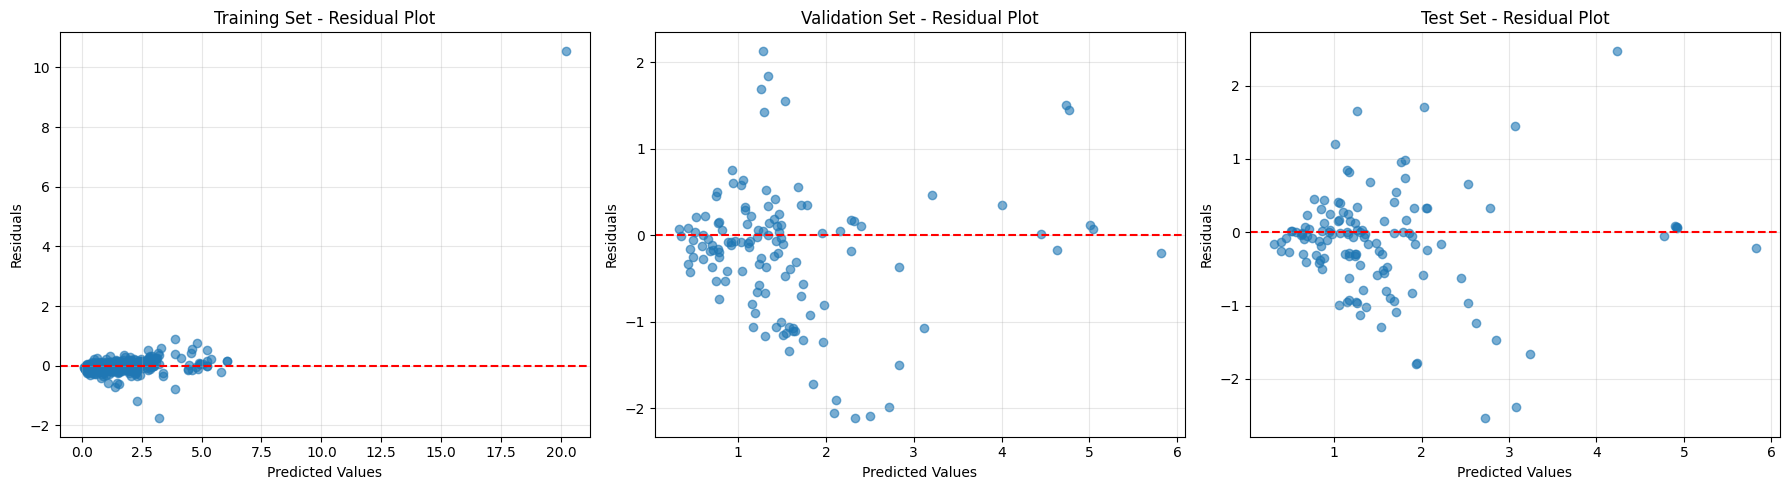

In [37]:
# Regression Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_actual_vs_predicted(y_true, y_pred, ax, title, metrics):
    ax.scatter(y_true, y_pred, alpha=0.6)
    
    # Perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{title} Set\nR² = {metrics["r2"]:.3f}, RMSE = {metrics["rmse"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plot_actual_vs_predicted(y_train, y_train_pred, axes[0], 'Training', train_metrics)
plot_actual_vs_predicted(y_val, y_val_pred, axes[1], 'Validation', val_metrics)
plot_actual_vs_predicted(y_test, y_test_pred, axes[2], 'Test', test_metrics)

plt.tight_layout()
plt.show()

# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_residuals(y_true, y_pred, ax, title):
    residuals = y_true - y_pred
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{title} Set - Residual Plot')
    ax.grid(True, alpha=0.3)

plot_residuals(y_train, y_train_pred, axes[0], 'Training')
plot_residuals(y_val, y_val_pred, axes[1], 'Validation')
plot_residuals(y_test, y_test_pred, axes[2], 'Test')

plt.tight_layout()
plt.show()

Number of features: 27
Number of importance values: 27
FEATURE IMPORTANCE RANKINGS
       feature  importance
       VH_Mean    0.080433
       dem_iqr    0.077619
       dem_min    0.076205
    pct_area_2    0.073918
       dem_max    0.071247
   VH_VV_Ratio    0.063547
      dem_mean    0.059956
        VH_Min    0.052550
     area_km_2    0.043052
         VH_SD    0.042213
        VV_Min    0.038598
       VV_Mean    0.036731
      hour_sin    0.034760
 precipitation    0.034385
         VV_SD    0.033758
        VV_IQR    0.030375
        VH_IQR    0.029783
        VV_Max    0.028306
     area_km_1    0.027812
    pct_area_1    0.024591
         cai_1    0.019113
         cai_2    0.007326
        VH_Max    0.006085
       day_sin    0.003258
          year    0.002518
     month_sin    0.001861
total_area_km2    0.000000


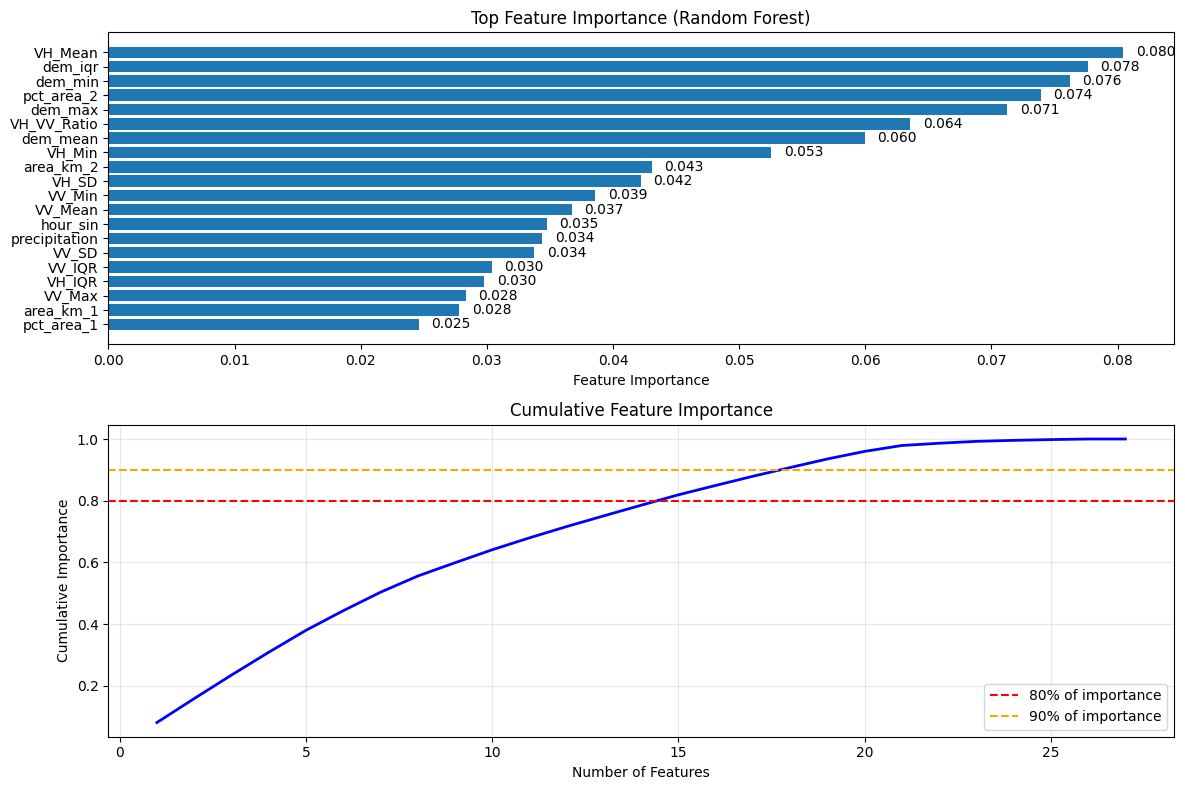


Feature Selection Insights:
Number of features needed for 80% of importance: 15
Number of features needed for 90% of importance: 18
Total number of features: 27

Feature importance saved to: C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\rf_feature_importance.csv


In [43]:
# Feature Importance Analysis
feature_importance = best_rf.feature_importances_

# Get feature names from the processed dataframe (after datetime conversion and numeric selection)
processed_features_df = df_wlabs.drop(['HWMdepth_m'], axis=1).select_dtypes(include=[np.number])
feature_names = processed_features_df.columns.tolist()

print(f"Number of features: {len(feature_names)}")
print(f"Number of importance values: {len(feature_importance)}")

# Ensure lengths match - if not, create generic names
if len(feature_names) != len(feature_importance):
    print("Warning: Feature names and importance lengths don't match. Using generic names.")
    feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("="*60)
print("FEATURE IMPORTANCE RANKINGS")
print("="*60)
print(importance_df.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

# Horizontal bar plot for top 20 features
top_features = importance_df.head(min(20, len(importance_df)))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance (Random Forest)')
plt.gca().invert_yaxis()

# Add importance values on bars
for i, v in enumerate(top_features['importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')

plt.subplot(2, 1, 2)

# Cumulative importance plot
cumulative_importance = np.cumsum(importance_df['importance'].values)
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% of importance')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% of importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of features needed for 80% and 90% of importance
idx_80 = np.argmax(cumulative_importance >= 0.8) + 1
idx_90 = np.argmax(cumulative_importance >= 0.9) + 1

print(f"\nFeature Selection Insights:")
print(f"Number of features needed for 80% of importance: {idx_80}")
print(f"Number of features needed for 90% of importance: {idx_90}")
print(f"Total number of features: {len(feature_importance)}")

# Save feature importance to CSV
importance_path = r'C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\rf_feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"\nFeature importance saved to: {importance_path}")

In [40]:
# Final Model Summary
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best Random Forest Parameters: {rf_optimized.best_params_}")
print(f"Best Cross-Validation Score (neg_MSE): {rf_optimized.best_score_:.4f}")
print(f"\nFinal Test Set Performance:")
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  MSE: {test_metrics['mse']:.4f}")

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"  Training R²: {train_metrics['r2']:.4f}")
print(f"  Validation R²: {val_metrics['r2']:.4f}")
print(f"  Test R²: {test_metrics['r2']:.4f}")
print(f"  Train-Val R² Gap: {train_metrics['r2'] - val_metrics['r2']:.4f}")
print(f"  Train-Test R² Gap: {train_metrics['r2'] - test_metrics['r2']:.4f}")

if train_metrics['r2'] - test_metrics['r2'] > 0.2:
    print("  WARNING: Potential overfitting detected (>20% R² gap between train and test)")
else:
    print("  Model shows good generalization")

print("\n" + "="*80)

FINAL MODEL SUMMARY
Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Best Cross-Validation Score (neg_MSE): -2.1062

Final Test Set Performance:
  R² Score: 0.6515
  RMSE: 0.7234
  MAE: 0.4832
  MSE: 0.5233

Overfitting Check:
  Training R²: 0.9199
  Validation R²: 0.6247
  Test R²: 0.6515
  Train-Val R² Gap: 0.2951
  Train-Test R² Gap: 0.2683



In [41]:
# Extract residuals with IDs for all data splits
print("="*60)
print("EXTRACTING RESIDUALS WITH IDs")
print("="*60)

# We need to reconstruct the full dataset with predictions to get residuals with IDs
# First, let's get predictions for the entire dataset
full_X = df_wlabs.drop(['HWMdepth_m'], axis=1).select_dtypes(include=[np.number]).values
full_y = df_wlabs['HWMdepth_m'].values
original_ids = df['ID'].values

# Standardize the full dataset using training statistics (same as used for model training)
full_X_norm = (full_X - X_mean) / X_std

# Get predictions for all samples
full_predictions = best_rf.predict(full_X_norm)

# Calculate residuals (actual - predicted)
residuals = full_y - full_predictions

# Create residuals dataframe with IDs
residuals_df = pd.DataFrame({
    'ID': original_ids,
    'Actual_HWMdepth_m': full_y,
    'Predicted_HWMdepth_m': full_predictions,
    'Residual': residuals,
    'Absolute_Residual': np.abs(residuals)
})

# Sort by ID for easier analysis
residuals_df = residuals_df.sort_values('ID')

# Display basic statistics
print(f"Total samples: {len(residuals_df)}")
print(f"Mean residual: {residuals_df['Residual'].mean():.4f}")
print(f"Std residual: {residuals_df['Residual'].std():.4f}")
print(f"Mean absolute residual: {residuals_df['Absolute_Residual'].mean():.4f}")

# Show first few rows
print(f"\nFirst 10 rows of residuals:")
print(residuals_df.head(10))

# Save to CSV
output_path = r'C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\rf_residuals.csv'
residuals_df.to_csv(output_path, index=False)
print(f"\nResiduals saved to: {output_path}")

# Additional analysis: identify largest residuals
print(f"\nTop 10 largest positive residuals (model under-predicted):")
print(residuals_df.nlargest(10, 'Residual')[['ID', 'Actual_HWMdepth_m', 'Predicted_HWMdepth_m', 'Residual']])

print(f"\nTop 10 largest negative residuals (model over-predicted):")
print(residuals_df.nsmallest(10, 'Residual')[['ID', 'Actual_HWMdepth_m', 'Predicted_HWMdepth_m', 'Residual']])

print(f"\nTop 10 largest absolute residuals:")
print(residuals_df.nlargest(10, 'Absolute_Residual')[['ID', 'Actual_HWMdepth_m', 'Predicted_HWMdepth_m', 'Residual']])

EXTRACTING RESIDUALS WITH IDs
Total samples: 841
Mean residual: -0.0502
Std residual: 0.5657
Mean absolute residual: 0.2373

First 10 rows of residuals:
      ID  Actual_HWMdepth_m  Predicted_HWMdepth_m  Residual  Absolute_Residual
712  770           4.720713              4.778321 -0.057608           0.057608
753  771           4.493530              4.484283  0.009247           0.009247
417  772           4.307705              4.430899 -0.123194           0.123194
827  773           4.985889              4.916995  0.068893           0.068893
70   774           4.982841              4.922125  0.060716           0.060716
522  775           4.739001              4.786724 -0.047724           0.047724
426  776           4.301609              4.429909 -0.128300           0.128300
347  777           4.463050              4.451412  0.011637           0.011637
264  778           4.988937              4.944384  0.044553           0.044553
755  779           4.982841              4.920629  0.0622